In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, callbacks
from keras.regularizers import l1
import pickle
import nltk
from random import randint, choice
import warnings
from flask import Flask, render_template, request

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

# Data Exploration

In [3]:
# read data

df = pd.read_csv('enron_dataset.csv', sep = ';').drop('Unnamed: 0', axis = 1)
df.head()

,Target,Message
0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...
1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...
2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...
3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...
4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Target   879 non-null    object
 1   Message  879 non-null    object
dtypes: object(2)
memory usage: 13.9+ KB


In [5]:
# check Nan values

df.isna().sum()

Target     0
Message    0
dtype: int64

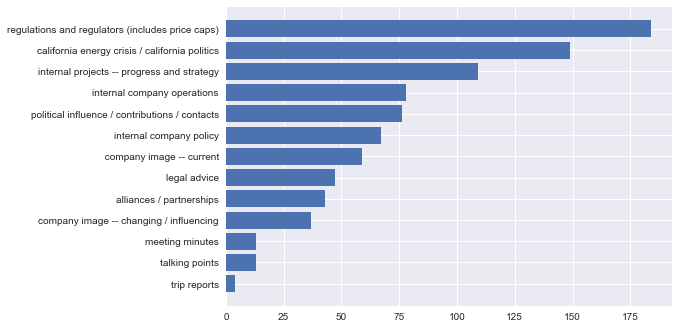

In [6]:
# visualize counts of each label

target_count = df.Target.value_counts()
plt.barh(target_count.index, target_count)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1]);

# Data Preparation

In [7]:
# define a function to extract the datetime from emails

def get_datetime(message):
    date = message.split('\n')[1][11:-12]
    return datetime.strptime(date, '%d %b %Y %H:%M:%S')

In [8]:
# define a function to extract the subject from emails

def get_subject(message):
    
    subject = message.split('\n')
    for s in subject:
        if s.startswith('Subject'):
            return s[9:]

In [9]:
# list to store elements(email heading) to be removed

element_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
 'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
 'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --']

In [10]:
# define a function to get the email content from message

def get_content(message):
    
    message = message.split('\n')
    message_copy = [ele for ele in message if ele != '']
    
    # remove the unwanted elements in the message
    for m in message:
        for e in element_to_drop:
            if m.startswith(e):
                message_copy.remove(m)
    return message_copy

In [11]:
# define a function to get receivers of email

def get_receiver(message):
    
    l = []
    for m in message:
        if m.startswith('X-To'):
            l.append(m[6:])
            l = l[0].split(', ')
    
    return l

In [12]:
# add receivers of email to the dataset

df2 = df.copy()
df2['Receiver'] = df2.Message.apply(lambda x: x.split('\n'))
df2['Receiver'] = df2.Receiver.apply(get_receiver)
df2.Receiver.head()

0    [GILBERT-SMITH@mailman.enron.com, Gilbert-smit...
1                                ['vkaminski@aol.com']
2    [Lay, Kenneth </O=ENRON/OU=NA/CN=RECIPIENTS/CN...
3                                    [Michael Terraso]
4    ['sbishop@gibbs-bruns.com', 'jalexander@gibbs-...
Name: Receiver, dtype: object

In [13]:
# define a dictionary to create key-value pairs of labels

labels = df.Target.unique()
labels_num = np.arange(len(labels))
labels_dict = dict(zip(labels_num, labels))
labels_dict

{0: 'internal company policy',
 1: 'alliances / partnerships',
 2: 'internal company operations',
 3: 'internal projects -- progress and strategy',
 4: 'regulations and regulators (includes price caps)',
 5: ' company image -- current',
 6: 'california energy crisis / california politics',
 7: 'meeting minutes',
 8: 'political influence / contributions / contacts',
 9: 'legal advice',
 10: 'talking points',
 11: 'company image -- changing / influencing',
 12: 'trip reports'}

# Data Cleaning

In [14]:
# define a list of stopwords

stopword_list = nltk.corpus.stopwords.words('english')
extra_stopwords = ['fw', 're']
stopword_list.extend(extra_stopwords)

In [15]:
# define a function to get the content of emails

def content_cleaning(content):
    
    # remove empty and None list elements 
    content = list(filter(lambda x: x.strip() not in ['', [], None], content))
    return ' '.join(content)

In [16]:
# define a function to remove punctuation, numbers, stop words, and redundant space from text

def text_cleaning(text):
    
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = ' '.join([item for item in text.split() if item not in stopword_list])
    text = text.strip()
    return text

In [17]:
# define a function to get senders of email

def get_sender(text):
    return text.split('\n')[2][6:] 

In [18]:
# define a function to perform data cleaning

def data_cleaning(df, train = True):
    
    df2 = df.copy()

    # extract datetime
    df2['Datetime'] = df.Message.apply(get_datetime)
    df2['Year'] = df2.Datetime.dt.year
    df2['Month'] = df2.Datetime.dt.month
    df2['Day'] = df2.Datetime.dt.day
    
    # email subject extraction
    df2['Subject'] = df.Message.apply(get_subject)
    # email content extraction
    df2['Content'] = df.Message.apply(get_content)
    
    if train:
        df2['Labels'] = df['Target'].replace(list(labels_dict.values()), list(labels_dict.keys()))
    
    # get cleaned email subject and content
    df2['Subject_cleaned'] = df2['Subject'].apply(text_cleaning)
    df2['Content_cleaned'] = df2['Content'].apply(content_cleaning)
    df2['Content_cleaned'] = df2['Content_cleaned'].apply(text_cleaning)
    
    # get email senders
    emails = df.Message.apply(get_sender)
    # one-hot encoding for email senders
    emails = pd.get_dummies(emails)
    
    return df2, emails

In [19]:
# define a function to create TF-IDF for text

def tfidf(df):
    
    vectorizer = TfidfVectorizer(ngram_range = (1, 4), max_features = 4500, use_idf = True)
    subject_tfidf = vectorizer.fit_transform(df.Subject_cleaned)
    content_tfidf = vectorizer.fit_transform(df.Content_cleaned)
    
    return vectorizer, subject_tfidf, content_tfidf

In [20]:
# define a function to get a list of email receivers

def get_receiver_list(receiver):
    
    receiver = [person for row in receiver for person in row if person != '']
    return list(set(receiver))

In [21]:
# get a list of receivers

receiver_list = get_receiver_list(df2.Receiver)
receiver_list[:10]

['Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=KPRESTO>',
 'Peter Styles',
 'Beck',
 'Richard Lewis',
 '"\'Smith',
 'Jennifer\'" <jennifer.hein@neg.pge.com>',
 'Michelle Lokay',
 'Holden </O=ENRON/OU=NA/CN=RECIPIENTS/CN=HSALISBU>',
 '"\'Kassandra Gough (E-mail)\'" <kgough@calpine.com>',
 'Mark E. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Mhaedic>']

In [22]:
# define a function to make one-hot encoding of receivers

def one_hot_encoding_receiver(df, receiver_list, train = True):
    
    df[receiver_list] = 0
    if train:
        df.drop(['Target', 'Message'], axis = 1, inplace = True)
    
    # loop through each row to perform one-hot encoding
    for row_index, row in enumerate(df.Receiver):
        for col in row:
            if col in df.columns:
                df.loc[row_index, col] = 1   
    df = df[receiver_list]
    return df

In [23]:
%time

# data cleaning for the dataset
df2, emails = data_cleaning(df2)
vectorizer, subject_tfidf, content_tfidf = tfidf(df2)
receivers = one_hot_encoding_receiver(df2, receiver_list)

CPU times: user 20.2 s, sys: 1.03 s, total: 21.2 s
Wall time: 30 s


In [24]:
# define a function to combine essential columns

def combine(df2, emails, receivers, subject_tfidf, content_tfidf):
    
    subject_tfidf_df = pd.DataFrame(subject_tfidf.toarray())
    content_tfidf_df = pd.DataFrame(content_tfidf.toarray())
    time = df2[['Year', 'Month', 'Day']]
    return pd.concat([time, emails, receivers, subject_tfidf_df, content_tfidf_df], axis = 1)

In [25]:
# prepare data for model training

X = combine(df2, emails, receivers, subject_tfidf, content_tfidf)
y = df2.Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Model Building

In [26]:
# define a neural network model 

model = Sequential([
#     Dense(1500, activation = 'relu', activity_regularizer = l1(0.001)),
    Dense(1000, activation = 'relu'),
    Dropout(0.4),
#     Dense(500, activation = 'relu'),
    Dense(len(labels_dict), activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', 
              metrics = ['accuracy'])

# define early stopping in case that accuracy doesn't imporve
my_callbacks = callbacks.EarlyStopping(monitor = 'accuracy', patience = 4)
model.fit(X_train, y_train, epochs = 100, callbacks = [my_callbacks])
result = model.evaluate(X_test, y_test)
result

Epoch 1/100
22/22 [==============================] - 5s 109ms/step - loss: 37.3328 - accuracy: 0.1366
Epoch 2/100
22/22 [==============================] - 2s 82ms/step - loss: 26.0876 - accuracy: 0.1550
Epoch 3/100
22/22 [==============================] - 2s 71ms/step - loss: 17.0611 - accuracy: 0.1309
Epoch 4/100
22/22 [==============================] - 2s 68ms/step - loss: 9.2492 - accuracy: 0.1821
Epoch 5/100
22/22 [==============================] - 2s 69ms/step - loss: 5.0297 - accuracy: 0.1849
Epoch 6/100
22/22 [==============================] - 2s 88ms/step - loss: 2.4712 - accuracy: 0.2831
Epoch 7/100
22/22 [==============================] - 2s 74ms/step - loss: 2.0921 - accuracy: 0.2987
Epoch 8/100
22/22 [==============================] - 2s 74ms/step - loss: 2.0369 - accuracy: 0.3243
Epoch 9/100
22/22 [==============================] - 2s 70ms/step - loss: 2.0978 - accuracy: 0.2788
Epoch 10/100
22/22 [==============================] - 2s 69ms/step - loss: 2.0965 - accuracy: 0.

[2.14521861076355, 0.23863635957241058]

In [24]:
# save the model

now = datetime.now().strftime('%Y-%m-%d %H_%M_%S')
filename = f'{round(result[1], 3)}_{now}.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model, file)

INFO:tensorflow:Assets written to: ram://552bdd1c-31b4-4ec4-9107-30f10feaa7c8/assets


In [27]:
# load saved model

model_loaded = pickle.load(open('0.398_2022-01-20 11_13_08.pkl', 'rb'))
model_loaded.evaluate(X_test, y_test)

6/6 [==============================] - 1s 79ms/step - loss: 2.1042 - accuracy: 0.3466


[2.104163408279419, 0.34659090638160706]

In [29]:
# get the configurations of the model

model_loaded.get_config()

{'name': 'sequential_15',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10972),
    'dtype': 'float64',
    'sparse': False,
    'ragged': False,
    'name': 'dense_30_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_30',
    'trainable': True,
    'dtype': 'float32',
    'units': 2000,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_11',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.4,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_31',
    'trainable': True,
    'dtype': 'float32',
    'units': 13,
   

In [30]:
print(f"Input shape: {model_loaded.get_config()['layers'][1]['config']['units']}")
# print(f"L1: {model_loaded.get_config()['layers'][1]['config']['activity_regularizer']['config']['l1']}")
print(f"Dropout: {model_loaded.get_config()['layers'][2]['config']['rate']}")
print(f"Activation: {model_loaded.get_config()['layers'][3]['config']['activation']}")

Input shape: 2000
Dropout: 0.4
Activation: sigmoid


# Prediction Preparation

In [28]:
# define a function to clean and prepare user input message from web application

def pred_data_cleaning(message, receiver_list):
    message_copy = pd.DataFrame([message], columns = ['Message'])
    message_df, message_emails = data_cleaning(message_copy, train = False)
    message_df['Receiver'] = message_df.Message.apply(lambda x: x.split('\n'))
    message_df.drop(['Message', 'Datetime', 'Subject', 'Content'], axis = 1, inplace = True)
    
    # encode the columns of senders of email as 0 if they are not the senders
    for c in emails.columns:
        if c not in message_emails.columns:
            message_emails[c] = 0
    
    message_subject_tfidf = vectorizer.transform(message_df.Subject_cleaned)
    message_content_tfidf = vectorizer.transform(message_df.Content_cleaned)
    message_df['Receiver'] = message_df.Receiver.apply(get_receiver)
    receivers = one_hot_encoding_receiver(message_df, receiver_list, train = False)
    
    message_df_final = combine(message_df, message_emails, receivers, 
                               message_subject_tfidf, message_content_tfidf)

    return message_df_final

In [29]:
# test the predictions

num = choice(X_test.index)
m = df.Message[num]

message = pred_data_cleaning(m, receiver_list)
prediction = model_loaded.predict(message)
print(labels_dict[prediction.argmax()])
print(labels_dict[y_test[num]])

california energy crisis / california politics
regulations and regulators (includes price caps)


In [30]:
testing = X_test.index
%store testing

Stored 'testing' (Int64Index)


# Launch Flask Web Application

In [31]:
# define a flask web application for user message input

app = Flask(__name__)

@app.route('/', methods = ['GET', 'POST'])
def home():
    if request.method == 'POST':
        user_message = request.form['text']
        user_message = user_message.replace('\\n', '\n')
        input_message = pred_data_cleaning(user_message, receiver_list)
        user_prediction = model_loaded.predict(input_message)
        pred_label = labels_dict[user_prediction.argmax()]
        return pred_label
    return render_template('index.html')

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Jan/2022 12:51:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2022 12:51:01] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [25/Jan/2022 12:51:05] "POST / HTTP/1.1" 200 -


# Discussion

The model achieves only around 38% of accuracy. The problems may be due to the followings:

    *Unbalaned data labels
    *Unstructured text body
    *Lack data
    
Improvements proposed:

    *More data, especially for inbalanced classes
    *Stemming
    *Lemmatization
    *More advanced models